In [45]:
import numpy as np
import networkx as nx
import torch
import time
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt
from torch import autograd


In this part, we focus on a simple road map (rep as a graph below), and generate random path on it.
<img src="img/naive_road.png" alt="Drawing" style="width: 400px;"/>

In [9]:
def one_hot(x, N = 24):
    l = np.zeros(24)
    l[x] = 1
    return l
def inv_one_hot(l, N = 24):
    return np.argmax(l)

In [10]:
def build_graph():
    G=nx.Graph()
    G.add_nodes_from(range(24))
    G.add_edges_from([(i, i+1) for i in range(5)] 
                     + [(i+6, i+7) for i in range(5)] 
                     +[(i+12, i+13) for i in range(5)]
                     + [(i+18, i+19) for i in range(5)]
                     + [(0,6),(6,12), (12,18)]
                     + [(pair[0]+1, pair[1]+1) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+2, pair[1]+2) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+3, pair[1]+3) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+4, pair[1]+4) for pair in [(0,6),(6,12), (12,18)]]
                     + [(pair[0]+5, pair[1]+5) for pair in [(0,6),(6,12), (12,18)]]
                     )
    return G

In [11]:
# gloable env
G = build_graph() 
N = len(G.node)

In [12]:
def random_path(start = None, stop_prob = 0.1):
    """
    Generate random path on graph G with lenght at least 2, encode each road in one-hot fashion
    """
    if not start:
        start = np.random.choice(24)
    path = [start]
    while True:
        nxt = np.random.choice(list(G.neighbors(start)))
        path.append(nxt)
        start = nxt
        if np.random.rand() < stop_prob:
            break
    return np.array(path)

In [29]:
p = random_path()
print(p)

[ 1  2  1  2  8  9 15 14 13 14  8  9 10  4]


In [30]:
def random_training_set():
    def f(x):
        if x == -1:
            return 0
        if x == -6:
            return 1
        if x == 1:
            return 2
        if x == 6:
            return 3
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    #import pdb; pdb.set_trace()
    tar = [f(x) for x in path[1:] - path[:-1]]
    tar = torch.from_numpy(np.array(tar))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [53]:
def random_training_set_with_road_tar():
    path = random_path()
    inp = torch.from_numpy(np.float32(np.array([one_hot(p) for p in path[:-1]])))
    tar = torch.from_numpy(np.array(path[1:]))
    return Variable(inp).contiguous(), Variable(tar).contiguous()

In [37]:
x,y = random_training_set()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} denotes the turning decistion at each road'.format(y.data.numpy()))

x: [21, 15, 21, 15, 16, 17, 23, 22, 16, 17, 11, 10, 11, 5, 4, 5, 11] is the sequence of road
y: [1 3 1 2 2 3 0 1 2 1 0 2 1 0 2 3 3] denotes the turning decistion at each road


In [54]:
x,y = random_training_set_with_road_tar()
print('x: {} is the sequence of road'.format([inv_one_hot(r) for r in x.data.numpy()]))
print('y: {} is the sequence of road'.format(y.data.numpy()))

x: [19, 18, 12, 18] is the sequence of road
y: [18 12 18 19] is the sequence of road


In [28]:
x.size()

torch.Size([3, 24])

Since we know the road transition are markov (turing decision only depends on current road), let start with *none-recurrent nn* to fit our transition

In [34]:
N_batch, D_in, D_hidden, D_out = 50, 24, 100, 4
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(D_hidden, D_out),
    torch.nn.Softmax(dim = 1),
)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = 0
n = 0
pts = {'x':[], 'y':[]}
for t in range(1,40001):
    x,y = random_training_set()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    L += sum(loss.data.numpy())
    n += len(loss.data.numpy())
    if t%1000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/n)
        print(t, L/n)
        L = 0
        n = 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


1000 1.34930958652
2000 1.33486124539
3000 1.33295213771
4000 1.33023302251
5000 1.33089588231
6000 1.32499839681
7000 1.33148761064
8000 1.32549153697
9000 1.32516176957
10000 1.32806896353
11000 1.32688594347
12000 1.32733261585
13000 1.3273271637
14000 1.32677630472
15000 1.3274006238
16000 1.32643326986
17000 1.32522372437
18000 1.32791907644
19000 1.3257893461
20000 1.32402183676
21000 1.32615646923
22000 1.32490739322
23000 1.3251738348
24000 1.32576821911
25000 1.32154965889
26000 1.32808812869
27000 1.3222162075
28000 1.32186228645
29000 1.32248628068
30000 1.32288641453
31000 1.32462305331
32000 1.32343855703
33000 1.32430543184
34000 1.32195827973
35000 1.32354878688
36000 1.32241541696
37000 1.32530014467
38000 1.32341906118
39000 1.32362381232
40000 1.32523345554


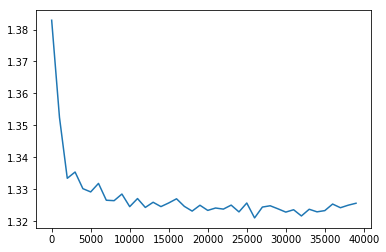

In [167]:
plt.plot(pts['x'],pts['y'])

In [35]:
x,y = random_training_set()
print([inv_one_hot(r) for r in x.data.numpy()])
model(x)

[16, 17, 11, 17]


Variable containing:
 0.2316  0.2603  0.2466  0.2615
 0.3101  0.3435  0.0003  0.3462
 0.3137  0.3652  0.0000  0.3212
 0.3101  0.3435  0.0003  0.3462
[torch.FloatTensor of size 4x4]

In [55]:
N_batch, D_in, D_hidden, D_out = 50, 24, 100, 24
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(D_hidden, D_out),
    torch.nn.Softmax(dim = 1),
)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
L = 0
n = 0
pts = {'x':[], 'y':[]}
for t in range(1,40001):
    x,y = random_training_set_with_road_tar()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    L += sum(loss.data.numpy())
    n += len(loss.data.numpy())
    if t%1000 == 0:
        pts['x'].append(t)
        pts['y'].append(L/n)
        print(t, L/n)
        L = 0
        n = 0
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


1000 2.97760281563
2000 2.91700273299
3000 2.92992539382
4000 2.91718449593
5000 2.92533947349
6000 2.92036879992
7000 2.90626250553
8000 2.93216746497
9000 2.91581888652
10000 2.91912127399
11000 2.91563740802
12000 2.91963133335
13000 2.92020012093
14000 2.91498957253
15000 2.91535791302
16000 2.91448263931
17000 2.91123799849
18000 2.92018643141
19000 2.92073032689
20000 2.91078437591
21000 2.91839484549
22000 2.90709405303
23000 2.91134590816
24000 2.91775816298
25000 2.91062480426
26000 2.91006576872
27000 2.91398421502
28000 2.90791724896
29000 2.91179870844
30000 2.909815763
31000 2.91398928905
32000 2.90989645672
33000 2.9068295784
34000 2.90682117033
35000 2.90661678171
36000 2.90852116871
37000 2.91106318307
38000 2.90966106319
39000 2.90774837184
40000 2.90353099585


In [68]:
x,y = random_training_set_with_road_tar()
print([inv_one_hot(r) for r in x.data.numpy()])
np.concatenate([model(x)[0,:].data.numpy().reshape(24,1), 
                np.array(range(0,24)).reshape(24,1)],
               axis = 1)

[1, 2, 1, 2, 3, 4, 5, 11, 17, 16, 17, 16, 15, 9, 10, 16, 10, 9, 15, 14, 15, 14]


array([[  4.37199265e-01,   0.00000000e+00],
       [  3.71897954e-06,   1.00000000e+00],
       [  2.81317681e-01,   2.00000000e+00],
       [  6.56606717e-05,   3.00000000e+00],
       [  4.71748899e-06,   4.00000000e+00],
       [  5.03337242e-06,   5.00000000e+00],
       [  1.33659299e-07,   6.00000000e+00],
       [  2.81017661e-01,   7.00000000e+00],
       [  2.29288531e-07,   8.00000000e+00],
       [  1.60154325e-08,   9.00000000e+00],
       [  4.30560021e-06,   1.00000000e+01],
       [  2.07785502e-04,   1.10000000e+01],
       [  3.50913353e-07,   1.20000000e+01],
       [  5.01797076e-05,   1.30000000e+01],
       [  5.30111029e-05,   1.40000000e+01],
       [  9.33980346e-07,   1.50000000e+01],
       [  5.96461359e-06,   1.60000000e+01],
       [  1.80349318e-07,   1.70000000e+01],
       [  1.14560827e-07,   1.80000000e+01],
       [  2.29891884e-06,   1.90000000e+01],
       [  4.93845037e-05,   2.00000000e+01],
       [  1.54733095e-06,   2.10000000e+01],
       [  

In [49]:
input
output

Variable containing:
 2.8194
[torch.FloatTensor of size 1]